<a href="https://colab.research.google.com/github/Maleehak/StackoverflowTagPrediction/blob/main/Predict_tags_on_StackOverflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict tags on StackOverflow with linear models

In this project, tags for posts from [StackOverflow](https://stackoverflow.com)are predicted. Multilabel classification approach was used.

### Libraries

Following libraries were needed:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

Downloads all data required:

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week1() 
    
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

--2021-01-20 18:08:53--  https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1939 (1.9K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   1.89K  --.-KB/s    in 0s      

2021-01-20 18:08:54 (29.2 MB/s) - ‘setup_google_colab.py’ saved [1939/1939]



  0%|          | 0.00/7.20M [00:00<?, ?B/s]

  0%|          | 0.00/2.17M [00:00<?, ?B/s]

  0%|          | 0.00/1.04M [00:00<?, ?B/s]

  0%|          | 0.00/5.09k [00:00<?, ?B/s]

### Text preprocessing

We will need to use a list of stop words. It can be downloaded from *nltk*:

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The dataset of post titles from StackOverflow.  splits  to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). Uploading the corpora using *pandas*:

In [ ]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [ ]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [ ]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [ ]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


*title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [ ]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. 

**Task 1 (TextPrepare).** Implementing the function *text_prepare*. After that, running the function *test_text_prepare* to test it on tiny cases.

In [ ]:
import re

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, '', text) 
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    text = [word for word in text.split() if word not in STOPWORDS]
    text = " ".join(text)
    return text

In [ ]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [ ]:
print(test_text_prepare())

Basic tests are passed.


Run your implementation for questions from file *text_prepare_tests.tsv*

In [ ]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [ ]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [ ]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word, calculating how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Finding 3 most popular tags and 3 most popular words in the train data.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from itertools import chain

#stringified_X_train=" ".join(x for x in X_train)
#words_counts = list(chain(*[word_tokenize(s) for s in sent_tokenize(stringified_X_train)]))
#words_counts=Counter(words_counts)
words_counts = Counter([word for line in X_train for word in line.split(' ')])

tags_counts = list(chain(*[s for s in y_train]))
tags_counts=Counter(tags_counts)

In [ ]:
X_train

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app',
 'get current time specific country via jquery',
 'configuring tomcat use ssl',
 'awesome nested set plugin add new children tree various levels',
 'create map json response ruby rails 3',
 'rspec test method called',
 'springboot catalina lifecycle exception',
 'import data excel mysql database using php',
 'obtaining object javalangclasst object parameterized type without constructing class q_uestion',
 'ipad selecting text inside text input tap',
 'jquerys function object',
 'eclipse c++ mingw lauch program terminated',
 'javascript call one prototype method another prototype method',
 'get intersection list sets',
 'longer able hide keyboard viewwilldisappear ios7',
 'fetch key json swift',
 'change pivot header template windows phone 8',
 'connectionstring encryption',
 'let ui refresh long running ui operation',
 'better way execute ruby file using python get

We are assuming that *tags_counts* and *words_counts* are dictionaries like `{'some_word_or_tag': frequency}`. After applying the sorting procedure, results will be look like this: `[('most_popular_word_or_tag', frequency), ('less_popular_word_or_tag', frequency), ...]`.

In [ ]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data. Testing code using the function *test_my_bag_of_words*.

In [ ]:
DICT_SIZE = 5000
vocabulary=words_counts.most_common(DICT_SIZE)
WORDS_TO_INDEX={word[0]:index for index,word in enumerate(vocabulary) }
INDEX_TO_WORD={index:word[0] for index,word in enumerate(vocabulary) }
ALL_WORDS = WORDS_TO_INDEX.keys()
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    array_words = list(*[word_tokenize(s) for s in sent_tokenize(text)])
    for word in array_words:
      index=words_to_index.get(word)
      if index!= None:
        result_vector[index]+=1
    return result_vector

In [ ]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers): 
      if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
        return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [ ]:
print(test_my_bag_of_words())

Basic tests are passed.


Now applying the implemented function to all samples (this might take up to a minute):

In [ ]:
from scipy import sparse as sp_sparse

In [ ]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


As you might notice, we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

**Task 3 (BagOfWords).** For the 11th row in *X_train_mybag* find how many non-zero elements it has. In this task the answer (variable *non_zero_elements_count*) should be an integer number, e.g. 20.

In [ ]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row)


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implementing function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Using *train* corpus to train a vectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),token_pattern='(\S+)')
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    X_val = tfidf_vectorizer.transform(X_val)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

checking whether  c++ or c# are in the vocabulary, as they are obviously important tokens in our tags prediction task:

In [ ]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [ ]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [ ]:
'c#' in tfidf_reversed_vocab.values()

True

In [ ]:
'c++' in tfidf_reversed_vocab.values()

True

In [ ]:
y_train

array([list(['r']), list(['php', 'mysql']), list(['c#']), ...,
       list(['python', 'datetime', 'pandas']),
       list(['javascript', 'jquery']), list(['java', 'list', 'generics'])],
      dtype=object)

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)

In [ ]:
y_val = mlb.transform(y_val)

Implementing the function *train_classifier* for training a classifier by using One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [ ]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """  
    clf = OneVsRestClassifier(LogisticRegression(random_state=0,max_iter=200)).fit(X_train, y_train) 
    return clf

Training the classifiers for different data transformations: *bag-of-words* and *tf-idf*.


In [ ]:
classifier_mybag = train_classifier(X_train_mybag, y_train)



In [ ]:
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now we can create predictions for the data. We will need two types of predictions: labels and scores.

In [ ]:

y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)



In [ ]:
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [ ]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype applicationjson required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails




Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implementing the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [ ]:
def print_evaluation_scores(y_val, predicted):
    
    print('Accuracy:'+ str(accuracy_score(y_val, predicted)))
    print('Micro F1-Score:'+ str(roc_auc_score(y_val, predicted, average='micro')))
    print('Macro F1-Score:'+ str(roc_auc_score(y_val, predicted, average='macro')))
    print('Weighted F1-Score:'+ str(roc_auc_score(y_val, predicted, average='weighted')))

    print('Micro Precision Score:'+ str(average_precision_score(y_val, predicted, average='micro')))
    print('Macro Precision Score:'+ str(average_precision_score(y_val, predicted, average='macro')))
    print('Weighted Precision Score:'+ str(average_precision_score(y_val, predicted, average='weighted')))


In [ ]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy:0.3534
Micro F1-Score:0.771188580018956
Macro F1-Score:0.7005840998517958
Weighted F1-Score:0.7685637700487317
Micro Precision Score:0.47413172429587663
Macro Precision Score:0.3379034179791469
Weighted Precision Score:0.5040441577223704
Tfidf
Accuracy:0.32653333333333334
Micro F1-Score:0.7542751936644578
Macro F1-Score:0.6833319610447418
Weighted F1-Score:0.7520874378654764
Micro Precision Score:0.44891401983651325
Macro Precision Score:0.31384650370517486
Weighted Precision Score:0.48199849169506437


We can plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Function *roc_auc* can make it. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [ ]:
from metrics import roc_auc
%matplotlib inline

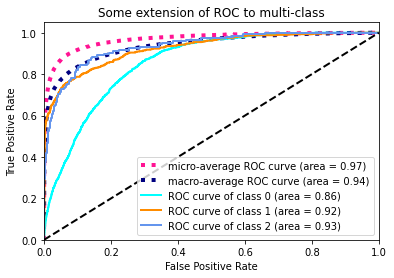

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

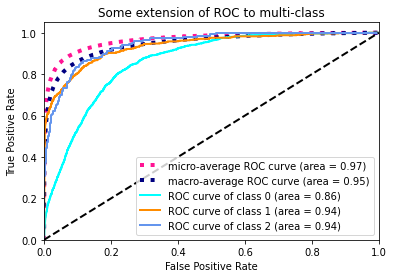

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)